# K-Nearest Neighbours

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
import pandas as pd
import seaborn as sns
from scipy.stats import uniform, normaltest
from sklearn import svm, neighbors, tree
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, validation_curve
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans,AgglomerativeClustering,SpectralClustering
from sklearn.preprocessing import normalize, PowerTransformer, OneHotEncoder, OrdinalEncoder, Normalizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score, plot_confusion_matrix,plot_roc_curve
from sklearn.metrics import rand_score,adjusted_mutual_info_score

## Importing Data and Pre-processing

In [2]:
# Import Data
data = pd.read_csv('data.txt',index_col=0)
pd.set_option('display.max_columns', 12)
data.head(7)

,nf1,nf1_amp1,nf1_amp2,nf1_amp3,nf1_amp4,nf1_amp5,...,nf9_amp2,nf9_amp3,nf9_amp4,nf9_amp5,Contains_Crack,Position_of_Crack
0,163.770,1.043534,1.043524,0.000001,1.043544,1.043534,...,0.053607,0.000155,0.053609,0.053611,No,No Crack
1,161.168,1.043284,1.038036,0.094323,1.031535,1.092445,...,0.069334,0.086817,0.460091,0.254838,Yes,Top Right
2,164.121,1.146271,1.026070,0.055705,1.013540,1.031031,...,0.391759,0.011229,0.163528,0.319310,Yes,Top Left
3,162.045,1.042523,1.045912,0.044661,1.056414,1.046251,...,0.053956,0.022008,0.054064,0.054362,Yes,Bottom Left
4,163.042,1.040145,1.030799,0.015596,1.043248,1.064751,...,0.053708,0.016016,0.057733,0.101230,Yes,Bottom Right
5,163.770,1.043534,1.043524,0.000001,1.043544,1.043534,...,0.053607,0.000155,0.053609,0.053611,No,No Crack
6,159.572,1.047045,1.027146,0.083370,1.042486,1.054308,...,0.146392,0.110386,0.068477,0.118288,Yes,Top Right


In [3]:
# Adding Noise
np.random.seed(1)
for col in data:
    if col != 'Contains_Crack' and col != 'Position_of_Crack':
        std_TR = np.std(data.loc[data['Position_of_Crack'] == 'Top Right', col])
        std_TL = np.std(data.loc[data['Position_of_Crack'] == 'Top Left', col])
        std_BL = np.std(data.loc[data['Position_of_Crack'] == 'Bottom Left', col])
        std_BR = np.std(data.loc[data['Position_of_Crack'] == 'Bottom Right', col])
        std_avg = (std_TR+std_TL+std_BL+std_BR)/4
    
        noise = np.random.uniform(-std_avg,std_avg,len(data[col]))
        data[col] = data[col] + noise
data.shape

(100, 56)

In [4]:
# Remove the target from the dataset
data.dropna(axis=0, subset=['Contains_Crack','Position_of_Crack'], inplace=True)
y1 = data.Contains_Crack
y2 = data.Position_of_Crack
data.drop(['Contains_Crack','Position_of_Crack'], axis=1, inplace=True)
data

,nf1,nf1_amp1,nf1_amp2,nf1_amp3,nf1_amp4,nf1_amp5,...,nf9,nf9_amp1,nf9_amp2,nf9_amp3,nf9_amp4,nf9_amp5
0,163.516307,1.038170,1.068703,0.021232,1.062176,0.830729,...,838.715944,0.142866,0.098044,0.036677,0.128474,0.030246
1,161.841610,1.044121,1.041205,0.119850,1.043862,0.951773,...,822.922837,0.565163,0.135012,0.129534,0.459730,0.288985
2,162.592673,1.158212,1.049316,0.068532,0.994574,0.935274,...,825.845806,0.053755,0.275476,0.058117,0.141599,0.425193
3,161.440661,1.038107,1.053830,0.049393,1.064906,0.878473,...,838.426601,0.120835,0.173844,-0.024460,0.083506,0.037301
4,161.962008,1.052786,1.024647,-0.007485,1.041829,1.119997,...,835.374843,0.085093,-0.047885,0.068026,0.031878,0.102733
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,162.965998,1.056900,1.019373,0.023410,1.061058,0.888231,...,843.224625,-0.005461,-0.050806,0.051564,0.064393,-0.022629
96,160.879274,1.022117,1.119511,0.082316,1.057186,0.832265,...,827.146286,0.127383,0.116638,0.248995,0.304281,0.077025
97,162.440264,1.028118,1.011183,0.019398,1.055071,0.977400,...,828.464281,0.000394,0.245330,0.056035,0.243257,0.208921
98,163.178099,1.018555,1.058280,0.050581,1.157652,0.794373,...,835.827020,0.500143,0.284131,0.042238,0.096635,0.045737


In [5]:
# Encoding targets
for idx in range(len(y1)):
    if y1[idx] == 'Yes':
        y1[idx] = int(1)
    elif y1[idx] == 'No': 
        y1[idx] = int(0)
    
    if y2[idx] == 'No Crack':
        y2[idx] = int(0)
    elif y2[idx] == 'Top Right':
        y2[idx] = int(1)
    elif y2[idx] == 'Top Left':
        y2[idx] = int(2)
    elif y2[idx] == 'Bottom Left':
        y2[idx] = int(3)
    elif y2[idx] == 'Bottom Right':
        y2[idx] = int(4)
y1.to_numpy(dtype=int)

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1])

In [6]:
# Split the data into feature sets
X1 = data
X2 = data[['nf1','nf2','nf3','nf4','nf5','nf6','nf7','nf8','nf9']]
amp1 = data[['nf1_amp1','nf2_amp1','nf3_amp1','nf4_amp1','nf5_amp1','nf6_amp1','nf7_amp1','nf8_amp1','nf9_amp1']].max(axis=1)
amp2 = data[['nf1_amp2','nf2_amp2','nf3_amp2','nf4_amp2','nf5_amp2','nf6_amp2','nf7_amp2','nf8_amp2','nf9_amp2']].max(axis=1)
amp3 = data[['nf1_amp3','nf2_amp3','nf3_amp3','nf4_amp3','nf5_amp3','nf6_amp3','nf7_amp3','nf8_amp3','nf9_amp3']].max(axis=1)
amp4 = data[['nf1_amp4','nf2_amp4','nf3_amp4','nf4_amp4','nf5_amp4','nf6_amp4','nf7_amp4','nf8_amp4','nf9_amp4']].max(axis=1)
amp5 = data[['nf1_amp5','nf2_amp5','nf3_amp5','nf4_amp5','nf5_amp5','nf6_amp5','nf7_amp5','nf8_amp5','nf9_amp5']].max(axis=1)
X3 = pd.DataFrame({'amp1':amp1,'amp2':amp2,'amp3':amp3,'amp4':amp4,'amp5':amp5})

In [7]:
# Splitting into testing and training for the different feature sets
X_train11, X_test11, y_train11, y_test11 = train_test_split(X1, y1.to_numpy(dtype=int), test_size=0.2, random_state = 0)
X_train21, X_test21, y_train21, y_test21 = train_test_split(X2, y1.to_numpy(dtype=int), test_size=0.2, random_state = 0)
X_train31, X_test31, y_train31, y_test31 = train_test_split(X3, y1.to_numpy(dtype=int), test_size=0.2, random_state = 0)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X1, y2.to_numpy(dtype=int), test_size=0.2, random_state = 0)
X_train22, X_test22, y_train22, y_test22 = train_test_split(X2, y2.to_numpy(dtype=int), test_size=0.2, random_state = 0)
X_train32, X_test32, y_train32, y_test32 = train_test_split(X3, y2.to_numpy(dtype=int), test_size=0.2, random_state = 0)

In [8]:
# Mean Center the data
for col in X_train11:
    X_test11.loc[:,col] = X_test11.loc[:,col] - X_train11.loc[:,col].mean()
    X_train11.loc[:,col] = X_train11.loc[:,col] - X_train11.loc[:,col].mean()
    
    X_test12.loc[:,col] = X_test12.loc[:,col] - X_train12.loc[:,col].mean()
    X_train12.loc[:,col] = X_train12.loc[:,col] - X_train12.loc[:,col].mean()

for col in X_train21:
    X_test21.loc[:,col] = X_test21.loc[:,col] - X_train21.loc[:,col].mean()
    X_train21.loc[:,col] = X_train21.loc[:,col] - X_train21.loc[:,col].mean()
    
    X_test22.loc[:,col] = X_test22.loc[:,col] - X_train22.loc[:,col].mean()
    X_train22.loc[:,col] = X_train22.loc[:,col] - X_train22.loc[:,col].mean()
    
for col in X_train31:
    X_test31.loc[:,col] = X_test31.loc[:,col] - X_train31.loc[:,col].mean()
    X_train31.loc[:,col] = X_train31[col] - X_train31[col].mean()
    
    X_test32.loc[:,col] = X_test32.loc[:,col] - X_train32.loc[:,col].mean()
    X_train32.loc[:,col] = X_train32.loc[:,col] - X_train32.loc[:,col].mean()

X_train11

C:\Users\James\anaconda3\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


,nf1,nf1_amp1,nf1_amp2,nf1_amp3,nf1_amp4,nf1_amp5,...,nf9,nf9_amp1,nf9_amp2,nf9_amp3,nf9_amp4,nf9_amp5
43,3.581602,-0.048451,-0.043658,0.052843,0.100453,-0.158342,...,-0.181764,0.356719,0.337481,0.177689,-0.074283,0.050663
62,1.604523,0.025551,0.007492,0.004462,-0.022159,0.030694,...,-1.271669,-0.142383,-0.115478,0.050465,0.031750,0.175242
3,-0.952166,-0.004978,0.001227,0.013602,0.016607,-0.294224,...,4.279401,-0.045163,0.043198,-0.098740,-0.060349,-0.100357
71,-0.730195,0.010480,-0.007981,-0.061000,-0.010028,0.055629,...,-0.387632,-0.141004,-0.026556,0.075769,0.035946,0.057299
45,1.217865,-0.011695,-0.002813,-0.025489,0.011686,-0.381480,...,5.493934,-0.156968,-0.144323,-0.128259,-0.087670,-0.010572
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,-1.513553,-0.020967,0.066908,0.046525,0.008887,-0.340432,...,-7.000913,-0.038615,-0.014008,0.174715,0.160426,-0.060633
67,-3.011306,-0.006248,-0.003369,0.057404,-0.000890,0.087405,...,7.184263,0.033165,-0.159252,0.001808,-0.146549,-0.198326
64,-0.468779,-0.010707,0.005931,0.009249,0.010759,0.015932,...,-0.832896,0.133012,0.014252,0.299752,-0.118206,0.112470
47,-0.152822,0.002789,-0.014487,-0.026338,0.009009,-0.223336,...,4.725110,-0.170896,-0.006564,-0.107392,0.075193,-0.076399


## No Scaling

Text(0.5, 1.0, 'Accuracy Score vs N')

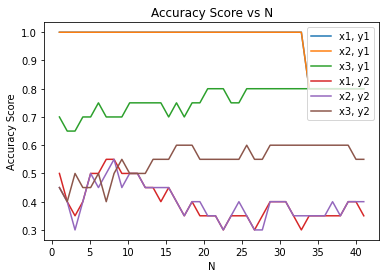

In [11]:
# NN Test
N = 40
accuracy_x1y1 = []
accuracy_x2y1 = []
accuracy_x3y1 = []
accuracy_x1y2 = []
accuracy_x2y2 = []
accuracy_x3y2 = []
for Ni in range(N):
    x1y1_nn = neighbors.KNeighborsClassifier(Ni+1)
    x1y1_nn.fit(X_train11, y_train11)    
    x1y1_predict = x1y1_nn.predict(X_test11)
    x1y1_accuracy_score = accuracy_score(y_test11,x1y1_predict)
    
    x2y1_nn = neighbors.KNeighborsClassifier(Ni+1)
    x2y1_nn.fit(X_train21, y_train21)
    x2y1_predict = x2y1_nn.predict(X_test21)
    x2y1_accuracy_score = accuracy_score(y_test21,x2y1_predict)
    
    x3y1_nn = neighbors.KNeighborsClassifier(Ni+1)
    x3y1_nn.fit(X_train31, y_train31)
    x3y1_predict = x3y1_nn.predict(X_test31)
    x3y1_accuracy_score = accuracy_score(y_test31,x3y1_predict)

    x1y2_nn = neighbors.KNeighborsClassifier(Ni+1)
    x1y2_nn.fit(X_train12, y_train12)
    x1y2_predict = x1y2_nn.predict(X_test12)
    x1y2_accuracy_score = accuracy_score(y_test12,x1y2_predict)
    
    x2y2_nn = neighbors.KNeighborsClassifier(Ni+1)
    x2y2_nn.fit(X_train22, y_train22)
    x2y2_predict = x2y2_nn.predict(X_test22)
    x2y2_accuracy_score = accuracy_score(y_test22,x2y2_predict)
    
    x3y2_nn = neighbors.KNeighborsClassifier(Ni+1)
    x3y2_nn.fit(X_train32, y_train32)
    x3y2_predict = x3y2_nn.predict(X_test32)
    x3y2_accuracy_score = accuracy_score(y_test32,x3y2_predict)    
    
    accuracy_x1y1.append(x1y1_accuracy_score)
    accuracy_x2y1.append(x2y1_accuracy_score)
    accuracy_x3y1.append(x3y1_accuracy_score)
    accuracy_x1y2.append(x1y2_accuracy_score)
    accuracy_x2y2.append(x2y2_accuracy_score)
    accuracy_x3y2.append(x3y2_accuracy_score)
    
plt.figure()
plt.plot(np.linspace(1,N+1,N),accuracy_x1y1,label="x1, y1")
plt.plot(np.linspace(1,N+1,N),accuracy_x2y1,label="x2, y1")
plt.plot(np.linspace(1,N+1,N),accuracy_x3y1,label="x3, y1")
plt.plot(np.linspace(1,N+1,N),accuracy_x1y2,label="x1, y2")
plt.plot(np.linspace(1,N+1,N),accuracy_x2y2,label="x2, y2")
plt.plot(np.linspace(1,N+1,N),accuracy_x3y2,label="x3, y2")
plt.legend(loc='upper right')
plt.xlabel("N")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Score vs N")

Predicted values using x1 and y1: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 1.0 and f1 score of: 1.0 and AUC score of 1.0 



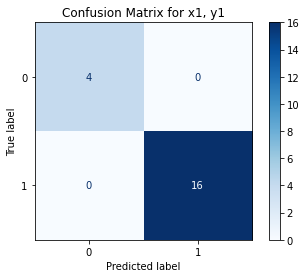

Predicted values using x2 and y1: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 1.0 and f1 score of: 1.0 and AUC score of 1.0 



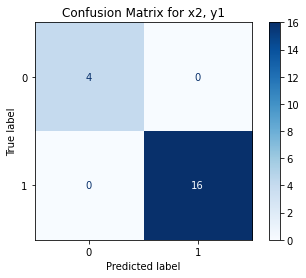

Predicted values using x3 and y1: [1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.85 and f1 score of: 0.9142857142857143 and AUC score of 0.625 



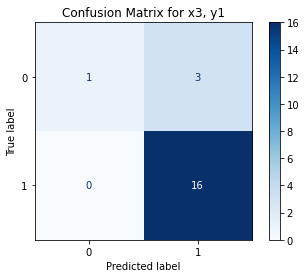

In [9]:
# Situation 1
# x1 y1
x1y1_nn = neighbors.KNeighborsClassifier(n_neighbors)
x1y1_nn.fit(X_train11, y_train11)

x1y1_predict = x1y1_nn.predict(X_test11)
x1y1_accuracy_score = accuracy_score(y_test11,x1y1_predict)
x1y1_f1_score = f1_score(y_test11,x1y1_predict)
x1y1_AUC_score = roc_auc_score(y_test11,x1y1_predict)

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y_test11)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and AUC score of",x1y1_AUC_score,"\n")
plot_confusion_matrix(x1y1_nn,X_test11,y_test11,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y1")
plt.show()

# x2 y1
x2y1_nn = neighbors.KNeighborsClassifier(n_neighbors)
x2y1_nn.fit(X_train21, y_train21)

x2y1_predict = x2y1_nn.predict(X_test21)
x2y1_accuracy_score = accuracy_score(y_test21,x2y1_predict)
x2y1_f1_score = f1_score(y_test21,x2y1_predict) 
x2y1_AUC_score = roc_auc_score(y_test21,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y_test21)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and AUC score of",x2y1_AUC_score,"\n")
plot_confusion_matrix(x2y1_nn,X_test21,y_test21,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y1")
plt.show()

# x3 y1
x3y1_nn = neighbors.KNeighborsClassifier(n_neighbors)
x3y1_nn.fit(X_train31, y_train31)

x3y1_predict = x3y1_nn.predict(X_test31)
x3y1_accuracy_score = accuracy_score(y_test31,x3y1_predict)
x3y1_f1_score = f1_score(y_test31,x3y1_predict)
x3y1_AUC_score = roc_auc_score(y_test31,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y_test31)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and AUC score of",x3y1_AUC_score,"\n")
plot_confusion_matrix(x3y1_nn,X_test31,y_test31,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y1")
plt.show()

Predicted values using x1 and y2: [1 1 2 0 0 3 1 3 2 0 2 4 3 4 2 0 2 4 3 4]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.75 and f1 score of: 0.7454545454545454 and AUC score of 0.9208333333333334 



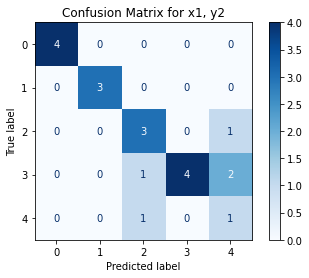

Predicted values using x2 and y2: [4 2 1 0 0 1 4 1 3 0 2 2 1 4 2 0 3 4 4 4]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.35 and f1 score of: 0.35 and AUC score of 0.656547619047619 



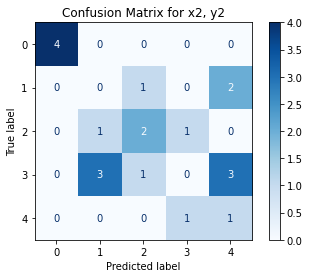

Predicted values using x3 and y2: [1 1 2 0 0 0 1 0 4 0 0 2 3 3 2 1 2 0 3 2]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.7 and f1 score of: 0.7116305916305916 and AUC score of 0.879761904761905 



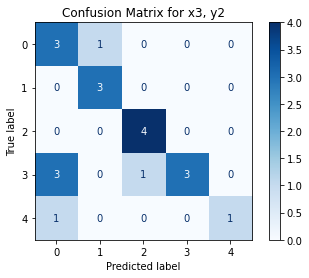

In [10]:
# Situation 2
# x1 y2
x1y2_nn = neighbors.KNeighborsClassifier(n_neighbors)
x1y2_nn.fit(X_train12, y_train12)

x1y2_predict = x1y2_nn.predict(X_test12)
x1y2_accuracy_score = accuracy_score(y_test12,x1y2_predict)
x1y2_f1_score = f1_score(y_test12,x1y2_predict,average='macro')
x1y2_y_prob = x1y2_nn.predict_proba(X_test12)
x1y2_AUC_score = roc_auc_score(y_test12,x1y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y_test12)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and AUC score of",x1y2_AUC_score,"\n")
plot_confusion_matrix(x1y2_nn,X_test12,y_test12,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y2")
plt.show()

# x2 y2
x2y2_nn = neighbors.KNeighborsClassifier(n_neighbors)
x2y2_nn.fit(X_train22, y_train22)

x2y2_predict = x2y2_nn.predict(X_test22)
x2y2_accuracy_score = accuracy_score(y_test22,x2y2_predict)
x2y2_f1_score = f1_score(y_test22,x2y2_predict,average='macro')
x2y2_y_prob = x2y2_nn.predict_proba(X_test22)
x2y2_AUC_score = roc_auc_score(y_test22,x2y2_y_prob,multi_class="ovo",average='macro')
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y_test22)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and AUC score of",x2y2_AUC_score,"\n")
plot_confusion_matrix(x2y2_nn,X_test22,y_test22,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y2")
plt.show()

# x3 y2
x3y2_nn = neighbors.KNeighborsClassifier(n_neighbors)
x3y2_nn.fit(X_train32, y_train32)

x3y2_predict = x3y2_nn.predict(X_test32)
x3y2_accuracy_score = accuracy_score(y_test32,x3y2_predict)
x3y2_f1_score = f1_score(y_test32,x3y2_predict,average='macro')
x3y2_y_prob = x3y2_nn.predict_proba(X_test32)
x3y2_AUC_score = roc_auc_score(y_test32,x3y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y_test32)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and AUC score of",x3y2_AUC_score,"\n")
plot_confusion_matrix(x3y2_nn,X_test32,y_test32,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y2")
plt.show()

## Normalisation

In [13]:
# Normalize the data
normalizer = Normalizer('l2')
X_train11_norm = pd.DataFrame(normalizer.fit_transform(X_train11))
X_test11_norm = pd.DataFrame(normalizer.transform(X_test11))
  
normalizer = Normalizer('l2')
X_train12_norm = pd.DataFrame(normalizer.fit_transform(X_train12))
X_test12_norm = pd.DataFrame(normalizer.transform(X_test12))

normalizer = Normalizer('l2')
X_train21_norm = pd.DataFrame(normalizer.fit_transform(X_train21))
X_test21_norm = pd.DataFrame(normalizer.transform(X_test21))

normalizer = Normalizer('l2')
X_train22_norm = pd.DataFrame(normalizer.fit_transform(X_train22))
X_test22_norm = pd.DataFrame(normalizer.transform(X_test22))

normalizer = Normalizer('l2')
X_train31_norm = pd.DataFrame(normalizer.fit_transform(X_train31))
X_test31_norm = pd.DataFrame(normalizer.transform(X_test31))

normalizer = Normalizer('l2')
X_train32_norm = pd.DataFrame(normalizer.fit_transform(X_train32))
X_test32_norm = pd.DataFrame(normalizer.transform(X_test32))

X_train32_norm

,0,1,2,3,4
0,0.397813,-0.238586,-0.095298,0.771969,0.424032
1,0.513168,-0.005580,-0.062190,-0.272431,-0.811506
2,-0.361775,-0.090618,0.079766,-0.494664,-0.780930
3,0.582187,0.047607,-0.104903,0.084496,-0.800404
4,-0.603528,0.077316,0.087650,0.217709,-0.758088
...,...,...,...,...,...
75,0.231797,0.803299,0.091714,0.215936,-0.495925
76,0.388689,0.401395,0.165437,0.481770,-0.654471
77,-0.121543,-0.348609,-0.077263,-0.228691,0.897458
78,-0.040054,0.067348,-0.045395,0.686705,0.721273


Text(0.5, 1.0, 'Accuracy Score vs N')

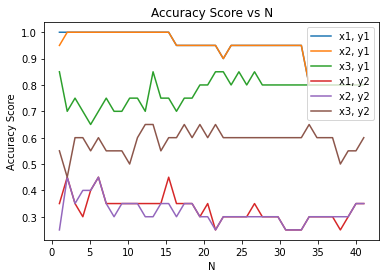

In [14]:
# NN Test
N = 40
accuracy_x1y1 = []
accuracy_x2y1 = []
accuracy_x3y1 = []
accuracy_x1y2 = []
accuracy_x2y2 = []
accuracy_x3y2 = []
for Ni in range(N):
    x1y1_nn = neighbors.KNeighborsClassifier(Ni+1)
    x1y1_nn.fit(X_train11_norm, y_train11)    
    x1y1_predict = x1y1_nn.predict(X_test11_norm)
    x1y1_accuracy_score = accuracy_score(y_test11,x1y1_predict)
    
    x2y1_nn = neighbors.KNeighborsClassifier(Ni+1)
    x2y1_nn.fit(X_train21_norm, y_train21)
    x2y1_predict = x2y1_nn.predict(X_test21_norm)
    x2y1_accuracy_score = accuracy_score(y_test21,x2y1_predict)
    
    x3y1_nn = neighbors.KNeighborsClassifier(Ni+1)
    x3y1_nn.fit(X_train31_norm, y_train31)
    x3y1_predict = x3y1_nn.predict(X_test31_norm)
    x3y1_accuracy_score = accuracy_score(y_test31,x3y1_predict)

    x1y2_nn = neighbors.KNeighborsClassifier(Ni+1)
    x1y2_nn.fit(X_train12_norm, y_train12)
    x1y2_predict = x1y2_nn.predict(X_test12_norm)
    x1y2_accuracy_score = accuracy_score(y_test12,x1y2_predict)
    
    x2y2_nn = neighbors.KNeighborsClassifier(Ni+1)
    x2y2_nn.fit(X_train22_norm, y_train22)
    x2y2_predict = x2y2_nn.predict(X_test22_norm)
    x2y2_accuracy_score = accuracy_score(y_test22,x2y2_predict)
    
    x3y2_nn = neighbors.KNeighborsClassifier(Ni+1)
    x3y2_nn.fit(X_train32_norm, y_train32)
    x3y2_predict = x3y2_nn.predict(X_test32_norm)
    x3y2_accuracy_score = accuracy_score(y_test32,x3y2_predict)    
    
    accuracy_x1y1.append(x1y1_accuracy_score)
    accuracy_x2y1.append(x2y1_accuracy_score)
    accuracy_x3y1.append(x3y1_accuracy_score)
    accuracy_x1y2.append(x1y2_accuracy_score)
    accuracy_x2y2.append(x2y2_accuracy_score)
    accuracy_x3y2.append(x3y2_accuracy_score)
    
plt.figure()
plt.plot(np.linspace(1,N+1,N),accuracy_x1y1,label="x1, y1")
plt.plot(np.linspace(1,N+1,N),accuracy_x2y1,label="x2, y1")
plt.plot(np.linspace(1,N+1,N),accuracy_x3y1,label="x3, y1")
plt.plot(np.linspace(1,N+1,N),accuracy_x1y2,label="x1, y2")
plt.plot(np.linspace(1,N+1,N),accuracy_x2y2,label="x2, y2")
plt.plot(np.linspace(1,N+1,N),accuracy_x3y2,label="x3, y2")
plt.legend(loc='upper right')
plt.xlabel("N")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Score vs N")

Predicted values using x1 and y1: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 1.0 and f1 score of: 1.0 and AUC score of 1.0 



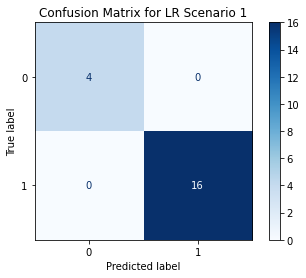

Predicted values using x2 and y1: [1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.95 and f1 score of: 0.9696969696969697 and AUC score of 0.875 



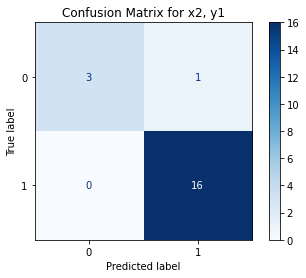

Predicted values using x3 and y1: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.8 and f1 score of: 0.888888888888889 and AUC score of 0.5 



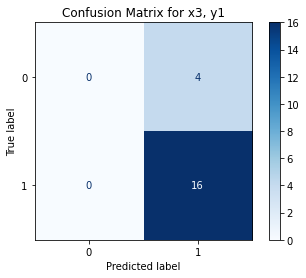

In [20]:
# Situation 1
# x1 y1
x1y1_nn = neighbors.KNeighborsClassifier(n_neighbors)
x1y1_nn.fit(X_train11_norm, y_train11)

x1y1_predict = x1y1_nn.predict(X_test11_norm)
x1y1_accuracy_score = accuracy_score(y_test11,x1y1_predict)
x1y1_f1_score = f1_score(y_test11,x1y1_predict)
x1y1_AUC_score = roc_auc_score(y_test11,x1y1_predict)

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y_test11)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and AUC score of",x1y1_AUC_score,"\n")
plot_confusion_matrix(x1y1_nn,X_test11_norm,y_test11,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for nn Scenario 1")
plt.show()

# x2 y1
x2y1_nn = neighbors.KNeighborsClassifier(n_neighbors)
x2y1_nn.fit(X_train21_norm, y_train21)

x2y1_predict = x2y1_nn.predict(X_test21_norm)
x2y1_accuracy_score = accuracy_score(y_test21,x2y1_predict)
x2y1_f1_score = f1_score(y_test21,x2y1_predict) 
x2y1_AUC_score = roc_auc_score(y_test21,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y_test21)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and AUC score of",x2y1_AUC_score,"\n")
plot_confusion_matrix(x2y1_nn,X_test21_norm,y_test21,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y1")
plt.show()

# x3 y1
x3y1_nn = neighbors.KNeighborsClassifier(n_neighbors)
x3y1_nn.fit(X_train31_norm, y_train31)

x3y1_predict = x3y1_nn.predict(X_test31_norm)
x3y1_accuracy_score = accuracy_score(y_test31,x3y1_predict)
x3y1_f1_score = f1_score(y_test31,x3y1_predict)
x3y1_AUC_score = roc_auc_score(y_test31,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y_test31)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and AUC score of",x3y1_AUC_score,"\n")
plot_confusion_matrix(x3y1_nn,X_test31_norm,y_test31,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y1")
plt.show()

Predicted values using x1 and y2: [2 0 4 0 0 1 4 2 2 0 2 2 1 4 2 0 1 4 4 4]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.35 and f1 score of: 0.3077777777777778 and AUC score of 0.7011904761904761 



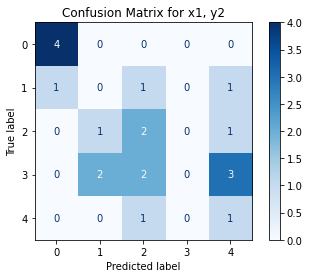

Predicted values using x2 and y2: [4 0 4 0 0 1 4 2 2 0 2 2 1 4 2 0 1 4 4 4]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.35 and f1 score of: 0.31111111111111117 and AUC score of 0.6738095238095239 



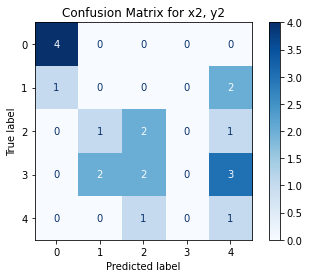

Predicted values using x3 and y2: [1 1 2 0 0 3 1 0 4 0 0 2 3 3 2 2 2 0 3 3]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.8 and f1 score of: 0.7977777777777777 and AUC score of 0.8505952380952382 



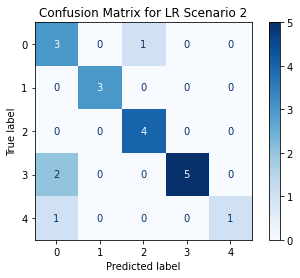

In [21]:
# Situation 2
# x1 y2
x1y2_nn = neighbors.KNeighborsClassifier(n_neighbors)
x1y2_nn.fit(X_train12_norm, y_train12)

x1y2_predict = x1y2_nn.predict(X_test12_norm)
x1y2_accuracy_score = accuracy_score(y_test12,x1y2_predict)
x1y2_f1_score = f1_score(y_test12,x1y2_predict,average='macro')
x1y2_y_prob = x1y2_nn.predict_proba(X_test12_norm)
x1y2_AUC_score = roc_auc_score(y_test12,x1y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y_test12)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and AUC score of",x1y2_AUC_score,"\n")
plot_confusion_matrix(x1y2_nn,X_test12_norm,y_test12,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y2")
plt.show()

# x2 y2
x2y2_nn = neighbors.KNeighborsClassifier(n_neighbors)
x2y2_nn.fit(X_train22_norm, y_train22)

x2y2_predict = x2y2_nn.predict(X_test22_norm)
x2y2_accuracy_score = accuracy_score(y_test22,x2y2_predict)
x2y2_f1_score = f1_score(y_test22,x2y2_predict,average='macro')
x2y2_y_prob = x2y2_nn.predict_proba(X_test22_norm)
x2y2_AUC_score = roc_auc_score(y_test22,x2y2_y_prob,multi_class="ovo",average='macro')
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y_test22)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and AUC score of",x2y2_AUC_score,"\n")
plot_confusion_matrix(x2y2_nn,X_test22_norm,y_test22,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y2")
plt.show()

# x3 y2
x3y2_nn = neighbors.KNeighborsClassifier(n_neighbors)
x3y2_nn.fit(X_train32_norm, y_train32)

x3y2_predict = x3y2_nn.predict(X_test32_norm)
x3y2_accuracy_score = accuracy_score(y_test32,x3y2_predict)
x3y2_f1_score = f1_score(y_test32,x3y2_predict,average='macro')
x3y2_y_prob = x3y2_nn.predict_proba(X_test32_norm)
x3y2_AUC_score = roc_auc_score(y_test32,x3y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y_test32)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and AUC score of",x3y2_AUC_score,"\n")
plot_confusion_matrix(x3y2_nn,X_test32_norm,y_test32,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for nn Scenario 2")
plt.show()

## Z Score Scaling

In [15]:
# Scaling
scaler = StandardScaler()
X_train11_z = scaler.fit_transform(X_train11)
X_test11_z = scaler.transform(X_test11)

scaler = StandardScaler()
X_train21_z = scaler.fit_transform(X_train21)
X_test21_z = scaler.transform(X_test21)

scaler = StandardScaler()
X_train31_z = scaler.fit_transform(X_train31)
X_test31_z = scaler.transform(X_test31)

scaler = StandardScaler()
X_train12_z = scaler.fit_transform(X_train12)
X_test12_z = scaler.transform(X_test12)

scaler = StandardScaler()
X_train22_z = scaler.fit_transform(X_train22)
X_test22_z = scaler.transform(X_test22)

scaler = StandardScaler()
X_train32_z = scaler.fit_transform(X_train32)
X_test32_z = scaler.transform(X_test32)

Text(0.5, 1.0, 'Accuracy Score vs N')

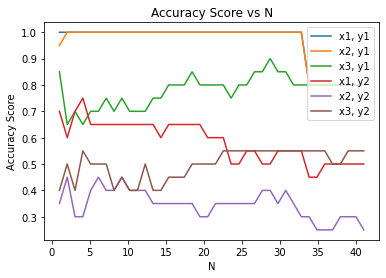

In [16]:
# NN Test
N = 40
accuracy_x1y1 = []
accuracy_x2y1 = []
accuracy_x3y1 = []
accuracy_x1y2 = []
accuracy_x2y2 = []
accuracy_x3y2 = []
for Ni in range(N):
    x1y1_nn = neighbors.KNeighborsClassifier(Ni+1)
    x1y1_nn.fit(X_train11_z, y_train11)    
    x1y1_predict = x1y1_nn.predict(X_test11_z)
    x1y1_accuracy_score = accuracy_score(y_test11,x1y1_predict)
    
    x2y1_nn = neighbors.KNeighborsClassifier(Ni+1)
    x2y1_nn.fit(X_train21_z, y_train21)
    x2y1_predict = x2y1_nn.predict(X_test21_z)
    x2y1_accuracy_score = accuracy_score(y_test21,x2y1_predict)
    
    x3y1_nn = neighbors.KNeighborsClassifier(Ni+1)
    x3y1_nn.fit(X_train31_z, y_train31)
    x3y1_predict = x3y1_nn.predict(X_test31_z)
    x3y1_accuracy_score = accuracy_score(y_test31,x3y1_predict)

    x1y2_nn = neighbors.KNeighborsClassifier(Ni+1)
    x1y2_nn.fit(X_train12_z, y_train12)
    x1y2_predict = x1y2_nn.predict(X_test12_z)
    x1y2_accuracy_score = accuracy_score(y_test12,x1y2_predict)
    
    x2y2_nn = neighbors.KNeighborsClassifier(Ni+1)
    x2y2_nn.fit(X_train22_z, y_train22)
    x2y2_predict = x2y2_nn.predict(X_test22_z)
    x2y2_accuracy_score = accuracy_score(y_test22,x2y2_predict)
    
    x3y2_nn = neighbors.KNeighborsClassifier(Ni+1)
    x3y2_nn.fit(X_train32_z, y_train32)
    x3y2_predict = x3y2_nn.predict(X_test32_z)
    x3y2_accuracy_score = accuracy_score(y_test32,x3y2_predict)    
    
    accuracy_x1y1.append(x1y1_accuracy_score)
    accuracy_x2y1.append(x2y1_accuracy_score)
    accuracy_x3y1.append(x3y1_accuracy_score)
    accuracy_x1y2.append(x1y2_accuracy_score)
    accuracy_x2y2.append(x2y2_accuracy_score)
    accuracy_x3y2.append(x3y2_accuracy_score)
    
plt.figure()
plt.plot(np.linspace(1,N+1,N),accuracy_x1y1,label="x1, y1")
plt.plot(np.linspace(1,N+1,N),accuracy_x2y1,label="x2, y1")
plt.plot(np.linspace(1,N+1,N),accuracy_x3y1,label="x3, y1")
plt.plot(np.linspace(1,N+1,N),accuracy_x1y2,label="x1, y2")
plt.plot(np.linspace(1,N+1,N),accuracy_x2y2,label="x2, y2")
plt.plot(np.linspace(1,N+1,N),accuracy_x3y2,label="x3, y2")
plt.legend(loc='upper right')
plt.xlabel("N")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Score vs N")

Predicted values using x1 and y1: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 1.0 and f1 score of: 1.0 and AUC score of 1.0 



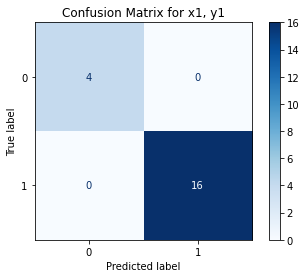

Predicted values using x2 and y1: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 1.0 and f1 score of: 1.0 and AUC score of 1.0 



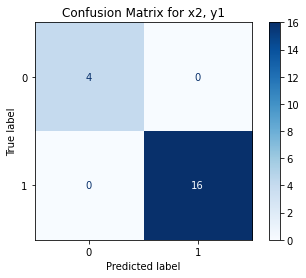

Predicted values using x3 and y1: [1 1 1 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.65 and f1 score of: 0.7407407407407406 and AUC score of 0.6875 



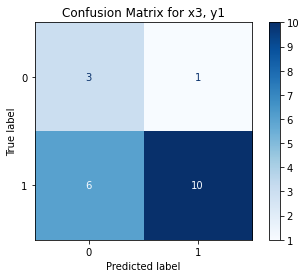

In [20]:
# Situation 1
n_neighbors = 4
# x1 y1
x1y1_nn = neighbors.KNeighborsClassifier(n_neighbors)
x1y1_nn.fit(X_train11_z, y_train11)

x1y1_predict = x1y1_nn.predict(X_test11_z)
x1y1_accuracy_score = accuracy_score(y_test11,x1y1_predict)
x1y1_f1_score = f1_score(y_test11,x1y1_predict)
x1y1_AUC_score = roc_auc_score(y_test11,x1y1_predict)

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y_test11)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and AUC score of",x1y1_AUC_score,"\n")
plot_confusion_matrix(x1y1_nn,X_test11_z,y_test11,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y1")
plt.show()

# x2 y1
x2y1_nn = neighbors.KNeighborsClassifier(n_neighbors)
x2y1_nn.fit(X_train21_z, y_train21)

x2y1_predict = x2y1_nn.predict(X_test21_z)
x2y1_accuracy_score = accuracy_score(y_test21,x2y1_predict)
x2y1_f1_score = f1_score(y_test21,x2y1_predict) 
x2y1_AUC_score = roc_auc_score(y_test21,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y_test21)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and AUC score of",x2y1_AUC_score,"\n")
plot_confusion_matrix(x2y1_nn,X_test21_z,y_test21,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y1")
plt.show()

# x3 y1
x3y1_nn = neighbors.KNeighborsClassifier(n_neighbors)
x3y1_nn.fit(X_train31_z, y_train31)

x3y1_predict = x3y1_nn.predict(X_test31_z)
x3y1_accuracy_score = accuracy_score(y_test31,x3y1_predict)
x3y1_f1_score = f1_score(y_test31,x3y1_predict)
x3y1_AUC_score = roc_auc_score(y_test31,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y_test31)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and AUC score of",x3y1_AUC_score,"\n")
plot_confusion_matrix(x3y1_nn,X_test31_z,y_test31,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y1")
plt.show()

Predicted values using x1 and y2: [1 1 2 0 0 3 1 1 3 0 3 2 3 2 2 0 2 1 3 4]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.75 and f1 score of: 0.6611111111111111 and AUC score of 0.9101190476190476 



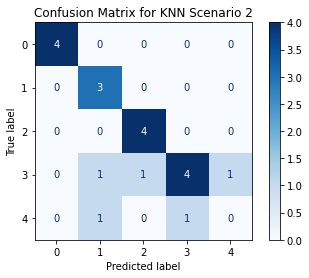

Predicted values using x2 and y2: [2 3 1 0 0 2 1 1 2 0 2 4 1 1 4 0 3 4 2 4]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.3 and f1 score of: 0.31666666666666665 and AUC score of 0.65 



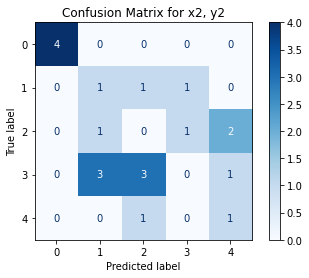

Predicted values using x3 and y2: [1 1 1 0 0 0 1 0 0 0 0 2 3 2 3 0 2 0 0 3]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.55 and f1 score of: 0.48 and AUC score of 0.7870535714285715 



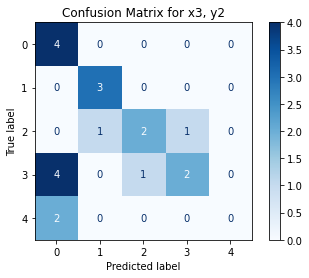

In [22]:
# Situation 2
n_neighbors = 4
# x1 y2
x1y2_nn = neighbors.KNeighborsClassifier(n_neighbors)
x1y2_nn.fit(X_train12_z, y_train12)

x1y2_predict = x1y2_nn.predict(X_test12_z)
x1y2_accuracy_score = accuracy_score(y_test12,x1y2_predict)
x1y2_f1_score = f1_score(y_test12,x1y2_predict,average='macro')
x1y2_y_prob = x1y2_nn.predict_proba(X_test12_z)
x1y2_AUC_score = roc_auc_score(y_test12,x1y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y_test12)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and AUC score of",x1y2_AUC_score,"\n")
plot_confusion_matrix(x1y2_nn,X_test12_z,y_test12,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for KNN Scenario 2")
plt.show()

# x2 y2
x2y2_nn = neighbors.KNeighborsClassifier(n_neighbors)
x2y2_nn.fit(X_train22_z, y_train22)

x2y2_predict = x2y2_nn.predict(X_test22_z)
x2y2_accuracy_score = accuracy_score(y_test22,x2y2_predict)
x2y2_f1_score = f1_score(y_test22,x2y2_predict,average='macro')
x2y2_y_prob = x2y2_nn.predict_proba(X_test22_z)
x2y2_AUC_score = roc_auc_score(y_test22,x2y2_y_prob,multi_class="ovo",average='macro')
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y_test22)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and AUC score of",x2y2_AUC_score,"\n")
plot_confusion_matrix(x2y2_nn,X_test22_z,y_test22,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y2")
plt.show()

# x3 y2
x3y2_nn = neighbors.KNeighborsClassifier(n_neighbors)
x3y2_nn.fit(X_train32_z, y_train32)

x3y2_predict = x3y2_nn.predict(X_test32_z)
x3y2_accuracy_score = accuracy_score(y_test32,x3y2_predict)
x3y2_f1_score = f1_score(y_test32,x3y2_predict,average='macro')
x3y2_y_prob = x3y2_nn.predict_proba(X_test32_z)
x3y2_AUC_score = roc_auc_score(y_test32,x3y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y_test32)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and AUC score of",x3y2_AUC_score,"\n")
plot_confusion_matrix(x3y2_nn,X_test32_z,y_test32,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y2")
plt.show()

## PCS

In [18]:
# PCA
pca = PCA()
X_train11_PCS = pca.fit_transform(X_train11)
X_test11_PCS = pca.transform(X_test11)

pca = PCA()
X_train21_PCS = pca.fit_transform(X_train21)
X_test21_PCS = pca.transform(X_test21)

pca = PCA()
X_train31_PCS = pca.fit_transform(X_train31)
X_test31_PCS = pca.transform(X_test31)

pca = PCA()
X_train12_PCS = pca.fit_transform(X_train12)
X_test12_PCS = pca.transform(X_test12)

pca = PCA()
X_train22_PCS = pca.fit_transform(X_train22)
X_test22_PCS = pca.transform(X_test22)

pca = PCA()
X_train32_PCS = pca.fit_transform(X_train32)
X_test32_PCS =pca.transform(X_test32)

X_train11_PCS

array([[ 8.37659537e+00, -1.16080732e+01,  7.95487810e+00, ...,
        -1.34124936e-03, -5.65870716e-03, -7.24118352e-03],
       [ 4.87317662e+01, -9.99852623e+00, -5.34152127e+00, ...,
        -7.09420798e-04, -1.15699969e-04,  8.88687730e-03],
       [-1.57985831e+01,  2.50768193e+00,  2.78375561e-02, ...,
         1.16349860e-02,  1.73482187e-02, -6.76086863e-03],
       ...,
       [ 5.52037369e+01, -9.04275557e+00, -4.27233908e+00, ...,
        -3.99463833e-03,  4.18074437e-03, -1.65960319e-03],
       [-2.32143736e+01, -8.27094459e+00, -3.85431951e+00, ...,
        -6.20281396e-03, -1.76908111e-03,  8.01055891e-03],
       [ 9.05585377e+00,  8.16018500e+00,  1.92691506e-01, ...,
         1.01637411e-02, -1.36464649e-02,  4.23947310e-03]])

Text(0.5, 1.0, 'Accuracy Score vs N')

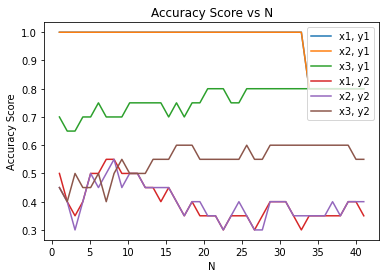

In [19]:
# NN Test
N = 40
accuracy_x1y1 = []
accuracy_x2y1 = []
accuracy_x3y1 = []
accuracy_x1y2 = []
accuracy_x2y2 = []
accuracy_x3y2 = []
for Ni in range(N):
    x1y1_nn = neighbors.KNeighborsClassifier(Ni+1)
    x1y1_nn.fit(X_train11_PCS, y_train11)    
    x1y1_predict = x1y1_nn.predict(X_test11_PCS)
    x1y1_accuracy_score = accuracy_score(y_test11,x1y1_predict)
    
    x2y1_nn = neighbors.KNeighborsClassifier(Ni+1)
    x2y1_nn.fit(X_train21_PCS, y_train21)
    x2y1_predict = x2y1_nn.predict(X_test21_PCS)
    x2y1_accuracy_score = accuracy_score(y_test21,x2y1_predict)
    
    x3y1_nn = neighbors.KNeighborsClassifier(Ni+1)
    x3y1_nn.fit(X_train31_PCS, y_train31)
    x3y1_predict = x3y1_nn.predict(X_test31_PCS)
    x3y1_accuracy_score = accuracy_score(y_test31,x3y1_predict)

    x1y2_nn = neighbors.KNeighborsClassifier(Ni+1)
    x1y2_nn.fit(X_train12_PCS, y_train12)
    x1y2_predict = x1y2_nn.predict(X_test12_PCS)
    x1y2_accuracy_score = accuracy_score(y_test12,x1y2_predict)
    
    x2y2_nn = neighbors.KNeighborsClassifier(Ni+1)
    x2y2_nn.fit(X_train22_PCS, y_train22)
    x2y2_predict = x2y2_nn.predict(X_test22_PCS)
    x2y2_accuracy_score = accuracy_score(y_test22,x2y2_predict)
    
    x3y2_nn = neighbors.KNeighborsClassifier(Ni+1)
    x3y2_nn.fit(X_train32_PCS, y_train32)
    x3y2_predict = x3y2_nn.predict(X_test32_PCS)
    x3y2_accuracy_score = accuracy_score(y_test32,x3y2_predict)    
    
    accuracy_x1y1.append(x1y1_accuracy_score)
    accuracy_x2y1.append(x2y1_accuracy_score)
    accuracy_x3y1.append(x3y1_accuracy_score)
    accuracy_x1y2.append(x1y2_accuracy_score)
    accuracy_x2y2.append(x2y2_accuracy_score)
    accuracy_x3y2.append(x3y2_accuracy_score)
    
plt.figure()
plt.plot(np.linspace(1,N+1,N),accuracy_x1y1,label="x1, y1")
plt.plot(np.linspace(1,N+1,N),accuracy_x2y1,label="x2, y1")
plt.plot(np.linspace(1,N+1,N),accuracy_x3y1,label="x3, y1")
plt.plot(np.linspace(1,N+1,N),accuracy_x1y2,label="x1, y2")
plt.plot(np.linspace(1,N+1,N),accuracy_x2y2,label="x2, y2")
plt.plot(np.linspace(1,N+1,N),accuracy_x3y2,label="x3, y2")
plt.legend(loc='upper right')
plt.xlabel("N")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Score vs N")

Predicted values using x1 and y1: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 1.0 and f1 score of: 1.0 and AUC score of 1.0 



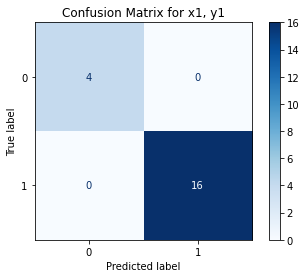

Predicted values using x2 and y1: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 1.0 and f1 score of: 1.0 and AUC score of 1.0 



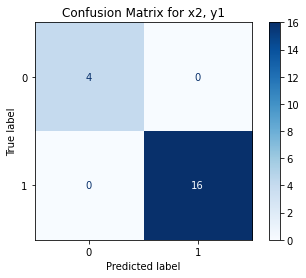

Predicted values using x3 and y1: [1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.85 and f1 score of: 0.9142857142857143 and AUC score of 0.625 



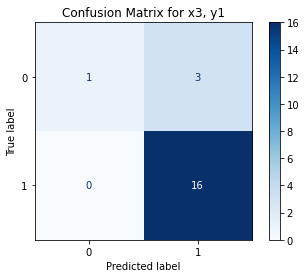

In [18]:
# Situation 1
# x1 y1
x1y1_nn = neighbors.KNeighborsClassifier(n_neighbors)
x1y1_nn.fit(X_train11_PCS, y_train11)

x1y1_predict = x1y1_nn.predict(X_test11_PCS)
x1y1_accuracy_score = accuracy_score(y_test11,x1y1_predict)
x1y1_f1_score = f1_score(y_test11,x1y1_predict)
x1y1_AUC_score = roc_auc_score(y_test11,x1y1_predict)

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y_test11)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and AUC score of",x1y1_AUC_score,"\n")
plot_confusion_matrix(x1y1_nn,X_test11_PCS,y_test11,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y1")
plt.show()

# x2 y1
x2y1_nn = neighbors.KNeighborsClassifier(n_neighbors)
x2y1_nn.fit(X_train21_PCS, y_train21)

x2y1_predict = x2y1_nn.predict(X_test21_PCS)
x2y1_accuracy_score = accuracy_score(y_test21,x2y1_predict)
x2y1_f1_score = f1_score(y_test21,x2y1_predict) 
x2y1_AUC_score = roc_auc_score(y_test21,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y_test21)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and AUC score of",x2y1_AUC_score,"\n")
plot_confusion_matrix(x2y1_nn,X_test21_PCS,y_test21,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y1")
plt.show()

# x3 y1
x3y1_nn = neighbors.KNeighborsClassifier(n_neighbors)
x3y1_nn.fit(X_train31_PCS, y_train31)

x3y1_predict = x3y1_nn.predict(X_test31_PCS)
x3y1_accuracy_score = accuracy_score(y_test31,x3y1_predict)
x3y1_f1_score = f1_score(y_test31,x3y1_predict)
x3y1_AUC_score = roc_auc_score(y_test31,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y_test31)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and AUC score of",x3y1_AUC_score,"\n")
plot_confusion_matrix(x3y1_nn,X_test31_PCS,y_test31,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y1")
plt.show()

Predicted values using x1 and y2: [1 1 2 0 0 3 1 3 2 0 2 4 3 4 2 0 2 4 3 4]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.75 and f1 score of: 0.7454545454545454 and AUC score of 0.9244047619047618 



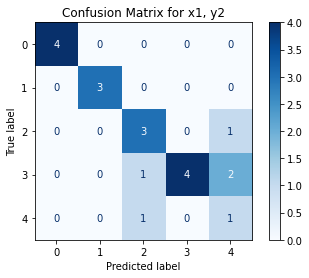

Predicted values using x2 and y2: [4 2 1 0 0 1 4 1 3 0 2 2 1 4 2 0 3 4 4 4]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.35 and f1 score of: 0.35 and AUC score of 0.656547619047619 



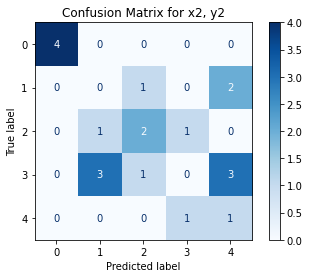

Predicted values using x3 and y2: [1 1 2 0 0 0 1 0 4 0 0 2 3 3 2 1 2 0 3 2]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.7 and f1 score of: 0.7116305916305916 and AUC score of 0.879761904761905 



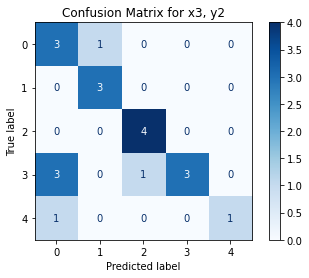

In [19]:
# Situation 2
# x1 y2
x1y2_nn = neighbors.KNeighborsClassifier(n_neighbors)
x1y2_nn.fit(X_train12_PCS, y_train12)

x1y2_predict = x1y2_nn.predict(X_test12_PCS)
x1y2_accuracy_score = accuracy_score(y_test12,x1y2_predict)
x1y2_f1_score = f1_score(y_test12,x1y2_predict,average='macro')
x1y2_y_prob = x1y2_nn.predict_proba(X_test12_PCS)
x1y2_AUC_score = roc_auc_score(y_test12,x1y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y_test12)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and AUC score of",x1y2_AUC_score,"\n")
plot_confusion_matrix(x1y2_nn,X_test12_PCS,y_test12,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y2")
plt.show()

# x2 y2
x2y2_nn = neighbors.KNeighborsClassifier(n_neighbors)
x2y2_nn.fit(X_train22_PCS, y_train22)

x2y2_predict = x2y2_nn.predict(X_test22_PCS)
x2y2_accuracy_score = accuracy_score(y_test22,x2y2_predict)
x2y2_f1_score = f1_score(y_test22,x2y2_predict,average='macro')
x2y2_y_prob = x2y2_nn.predict_proba(X_test22_PCS)
x2y2_AUC_score = roc_auc_score(y_test22,x2y2_y_prob,multi_class="ovo",average='macro')
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y_test22)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and AUC score of",x2y2_AUC_score,"\n")
plot_confusion_matrix(x2y2_nn,X_test22_PCS,y_test22,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y2")
plt.show()

# x3 y2
x3y2_nn = neighbors.KNeighborsClassifier(n_neighbors)
x3y2_nn.fit(X_train32_PCS, y_train32)

x3y2_predict = x3y2_nn.predict(X_test32_PCS)
x3y2_accuracy_score = accuracy_score(y_test32,x3y2_predict)
x3y2_f1_score = f1_score(y_test32,x3y2_predict,average='macro')
x3y2_y_prob = x3y2_nn.predict_proba(X_test32_PCS)
x3y2_AUC_score = roc_auc_score(y_test32,x3y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y_test32)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and AUC score of",x3y2_AUC_score,"\n")
plot_confusion_matrix(x3y2_nn,X_test32_PCS,y_test32,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y2")
plt.show()